Kaggle Link: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

## IMPORTS

In [ ]:
!pip install prince
!pip install bioinfokit

import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
from prince import FAMD
from bioinfokit.visuz import cluster
import matplotlib.image as mpimg

%matplotlib inline

     |████████████████████████████████| 84 kB 1.6 MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.8-py3-none-any.whl size=56749 sha256=8d009bbcad03dbe73842eadf3a171fa1344397056039fe8cca3cf718d0f53704
  Stored in directory: /root/.cache/pip/wheels/0d/b0/a4/2be59655e33c889f2197d43e99ed077f05a6559e24ce28e21a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=9bf1a55ea5ce3fcd381a6f01ea8edfd874b14a5556a8bc2b1f4639b06e17275e
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText


In [ ]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRCR69JUKdsMNNgJNhQIhPLIZ7ilQJJLfGWPRpFsrLn9-emAeaCJWTgvfg7Kzk0HGHWYwrTjSD_qM9W/pub?output=csv')
df = df.drop('id',axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


### Only column bmi has non-null values, so we'll have to edit this column accordingly

In [ ]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


#Cleaning the Data

### Since we have a few missing values for bmi, we will replace it with the mean bmi value for each gender 

####According to the CDC: https://www.cdc.gov/nchs/data/nhanes/databriefs/adultweight.pdf

*   Mean bmi value for female = 26.5 
*   Mean bmi value for male = 26.6




In [ ]:
miss_female_bmi = df[(df.gender == 'Female') & (df.bmi.isna())].index
miss_female_bmi

Int64Index([   1,    8,   43,   46,   50,   54,   70,   78,   81,  112,  124,
             129,  133,  150,  160,  162,  171,  174,  178,  183,  218,  360,
             432,  668,  729,  742,  867,  872,  879,  903,  936, 1102, 1106,
            1194, 1241, 1277, 1300, 1306, 1324, 1342, 1503, 1528, 1644, 1646,
            1650, 1756, 1836, 1837, 1981, 1993, 2109, 2192, 2263, 2322, 2343,
            2477, 2529, 2697, 2739, 2752, 2867, 2879, 2914, 3007, 3028, 3048,
            3059, 3074, 3104, 3164, 3214, 3216, 3375, 3382, 3425, 3431, 3562,
            3681, 3699, 3734, 3802, 3808, 3913, 3945, 3951, 4046, 4164, 4230,
            4255, 4422, 4451, 4561, 4684, 4713, 4750, 5093, 5105],
           dtype='int64')

In [ ]:
df.loc[miss_female_bmi, 'bmi'] = 26.5

In [ ]:
miss_male_bmi = df[(df.gender == 'Male') & (df.bmi.isna())].index
miss_male_bmi

Int64Index([  13,   19,   27,   29,   51,   57,   64,   84,  105,  126,
            ...
            4522, 4616, 4790, 4921, 4934, 4949, 4984, 5039, 5048, 5099],
           dtype='int64', length=104)

In [ ]:
df.loc[miss_male_bmi, 'bmi'] = 26.6

In [ ]:
df.info() #check whether there are still null values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [ ]:
# we see there are no null values! 

In [ ]:
#for our analysis, we will need to replace all object values in the dataset with int64 values
#the following columns have object values: gender, ever_married, work_type, Residence_type, smoking_status

In [ ]:
df['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [ ]:
mapping = {'Male': 1, 'Female': 2, 'Other': 3} #MALE = 1, FEMALE = 2, OTHER = 3
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 2, 'Other': 3})
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,2,61.0,0,0,Yes,Self-employed,Rural,202.21,26.5,never smoked,1
2,1,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,2,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,2,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
df['ever_married'] = df['ever_married'].replace({'Yes': 1, 'No': 0}) #YES = 1, NO = 0
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,2,61.0,0,0,1,Self-employed,Rural,202.21,26.5,never smoked,1
2,1,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,2,49.0,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,2,79.0,1,0,1,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [ ]:
df['work_type'] = df['work_type'].replace({'Private': 1, 'Self-employed': 2, 'Govt_job': 3, 'children':4, 'Never_worked':5}) #as seen on left
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,1,Urban,228.69,36.6,formerly smoked,1
1,2,61.0,0,0,1,2,Rural,202.21,26.5,never smoked,1
2,1,80.0,0,1,1,1,Rural,105.92,32.5,never smoked,1
3,2,49.0,0,0,1,1,Urban,171.23,34.4,smokes,1
4,2,79.0,1,0,1,2,Rural,174.12,24.0,never smoked,1


In [ ]:
df['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

In [ ]:
df['Residence_type'] = df['Residence_type'].replace({'Urban': 1, 'Rural': 2}) #URBAN = 1, RURAL = 2
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,1,1,228.69,36.6,formerly smoked,1
1,2,61.0,0,0,1,2,2,202.21,26.5,never smoked,1
2,1,80.0,0,1,1,1,2,105.92,32.5,never smoked,1
3,2,49.0,0,0,1,1,1,171.23,34.4,smokes,1
4,2,79.0,1,0,1,2,2,174.12,24.0,never smoked,1


In [ ]:
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [ ]:
df['smoking_status'] = df['smoking_status'].replace({'formerly smoked': 1, 'never smoked': 0, 'smokes': 2, 'Unknown':3}) #as seen on left
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,1,1,228.69,36.6,1,1
1,2,61.0,0,0,1,2,2,202.21,26.5,0,1
2,1,80.0,0,1,1,1,2,105.92,32.5,0,1
3,2,49.0,0,0,1,1,1,171.23,34.4,2,1
4,2,79.0,1,0,1,2,2,174.12,24.0,0,1


In [ ]:
df.info() #to make sure all columns have either int64 or float64 values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int64  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int64  
 5   work_type          5110 non-null   int64  
 6   Residence_type     5110 non-null   int64  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   int64  
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 439.3 KB


# Data Classification - Unsupervised Learning Algorithms

We will use unsupervised learning algorithms on our dataset to see if there are any obvious groupings, and see how our algorithms cluster the datapoints. We can use this information to see what variables have the highest variance and contribute the most to stroke prediction. 

## Factor Analysis of Mixed Data

When we have datasets with both continous and categorical variables, FAMD is an option. While MFA uses Factor Analysis, FAMD is a mix of two different dimensional reduction algorithms that is dependent on the type of data: PCA on continous variables, and MCA on cateogorical. 

In [ ]:
# For FAMD, we do not need to encode categoricals to binary. Simliar to before we will fill in missing BMI values with averages to avoid null observations
df_raw = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRCR69JUKdsMNNgJNhQIhPLIZ7ilQJJLfGWPRpFsrLn9-emAeaCJWTgvfg7Kzk0HGHWYwrTjSD_qM9W/pub?output=csv')
df_raw = df_raw.drop('id',axis=1)
bmi_female_missing = df_raw[(df_raw.gender == 'Female') & (df_raw.bmi.isna())].index
df_raw.loc[bmi_female_missing, 'bmi'] = 26.5
bmi_male_missing = df_raw[(df_raw.gender == 'Male') & (df_raw.bmi.isna())].index
df_raw.loc[bmi_male_missing, 'bmi'] = 26.6

# Build FAMD model with 10 principal comnponents
famd = FAMD(n_components = 10, n_iter = 3, random_state = 101)

famd.fit(df_raw)
famd.transform(df_raw)

,0,1,2,3,4,5,6,7,8,9
0,2.690869,3.384138,-0.848107,-0.888992,-0.391089,2.341200,0.164302,0.337657,0.096254,0.017989
1,1.579181,1.588746,-1.082789,1.904952,0.763470,1.623829,0.190251,-1.273900,0.629101,0.100600
2,2.218201,2.553851,-1.645267,-0.573707,1.373536,1.688333,-0.170097,1.439631,1.095623,-0.362003
3,1.411262,1.002839,-1.067238,1.296386,-0.762686,2.547598,-0.411694,0.116618,-0.672774,-0.706512
4,2.316877,2.122814,-0.611813,3.111136,0.742268,0.110205,-0.332885,-0.223373,0.379264,0.185055
...,...,...,...,...,...,...,...,...,...,...
5105,1.330075,-0.183338,0.128803,1.356255,-0.471021,-1.280480,0.103230,1.190481,0.098739,0.582379
5106,1.447708,-0.678234,-0.300798,0.213716,-0.581430,-0.381021,0.710780,-0.691916,0.400173,0.279772
5107,0.190660,-0.676310,-0.327898,0.363517,0.828043,-0.560541,0.440940,-0.444550,0.375356,0.192616
5108,0.554856,0.298697,0.626261,-0.683914,0.471915,0.410818,-0.571356,-0.891511,-0.218240,0.836893


#### Screeplot

Here is a plot to see what the contribution of each component is

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


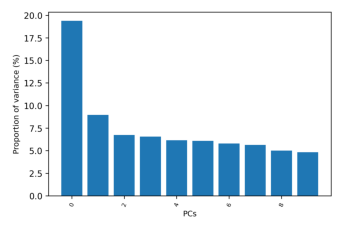

In [ ]:
cluster.screeplot(obj=[range(0,famd.n_components), famd.explained_inertia_])
# Saves output as screeplot.png, for best resolution run the code and download the png file.
# For convenience will use a lower resolution image here
img = mpimg.imread('screeplot.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

It seems that the first component is able to explain 19.38% of the distribution and the second component is able to explain only 8.96%. Due to the low values of the proportion of variance, I will only focus on the first two components.

#### Component Coordinate Plot

Lets see how the dataset projects onto the XY subspace of the first component and the second component to see how much each component explains the data. We also color-labeled by stroke to see how stroke patients and non-stroke patients cluster based on the components.

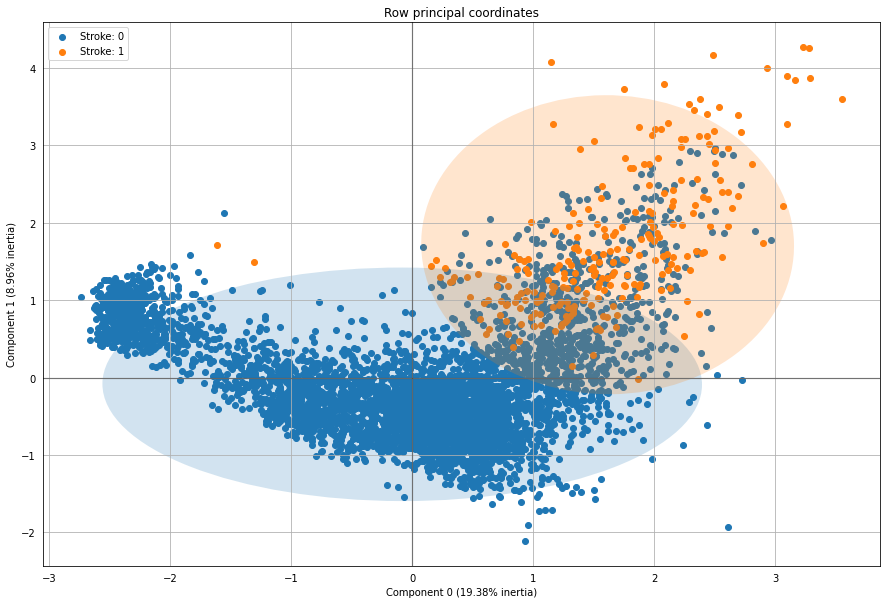

In [ ]:
famd.plot_row_coordinates(df_raw,figsize=(15, 10),color_labels=['Stroke: {}'.format(t) for t in df_raw['stroke']] )

Along the first component there seems to be two different clusters with some overlap. This means that there is some relationship between the first component and the likelihood of strokes, and since it has the highest inertia the first component will matter more to the distribution than the second component (x axis matters more than the y axis). We should find out which observed variables contributed to the first two component. 

#### Finding the Loading Factors

Lets see how much each varaible contributed to each principal component (loading factor)

In [ ]:
famd.column_correlations(df_raw)

,0,1,2,3,4,5,6,7,8,9
Residence_type_Rural,-0.006138,0.004606,0.008149,0.013308,-0.005773,0.007701,0.005326,-0.002693,-0.008264,-0.004496
Residence_type_Urban,0.006138,-0.004606,-0.008149,-0.013308,0.005773,-0.007701,-0.005326,0.002693,0.008264,0.004496
age,0.816725,0.210748,0.075759,-0.436235,-0.113539,0.080115,0.197193,-0.362236,-0.155937,0.561077
avg_glucose_level,0.739877,0.989507,0.980904,0.745742,-0.983883,0.981563,0.998094,-0.990850,-0.942351,0.793349
bmi,0.437248,0.020137,0.213315,-0.235793,-0.245338,0.214675,0.108227,-0.165668,-0.440060,-0.205461
ever_married_No,-0.566928,-0.118145,-0.057823,0.326918,0.086333,-0.060662,-0.121585,0.235711,0.139799,-0.318951
ever_married_Yes,0.566928,0.118145,0.057823,-0.326918,-0.086333,0.060662,0.121585,-0.235711,-0.139799,0.318951
gender_Female,-0.009580,-0.060123,-0.058018,-0.066814,0.055687,-0.057489,-0.057574,0.049343,0.042945,-0.039364
gender_Male,0.009636,0.059755,0.057669,0.066281,-0.055359,0.057140,0.057223,-0.049062,-0.042685,0.039109
gender_Other,-0.001952,0.013107,0.012450,0.018915,-0.011664,0.012424,0.012487,-0.009996,-0.009276,0.009065


It seems that in the first component that contributes 19.38%, the variable that influences it the most is age and to a lesser degree, average glucose level.

In the second component that contributes 8.96%, the variable that pretty much defines the component is average glucose level.


### Results

Therefore, by running FAMD the two variables that explains the most about stroke likelihood are <b>age and average glucose level</b>, which also passes our sanity check as it makes sense as there are proven relationships between age and stroke risk, as well as glucose level (diabetes) and stroke risk. 

Stroke Risk and Age: https://www.cdc.gov/stroke/risk_factors.htm

Stroke Risk and Diabetes: https://www.stroke.org/en/about-stroke/stroke-risk-factors/diabetes-and-stroke-prevention

### Discussion

Since the inertia for the first two components were pretty low (compared to typical values of above 50%), I would want to see a new dataset on stroke and see if we can find latent variables wich a higher explanatory power. I would also want to try and run Multi Factor Analysis (MFA) as that is another algorithm that can work on mixtures of categorical and continious data. 

### K Means

In [ ]:
# Only interested in data looking at bmi, glucose, & age to see its effects on strokes
df_sub_effects = df.copy(deep = True)
# Can now remove everything besides our 3 effects 
df_sub_effects = df_sub_effects.drop(columns=['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'work_type', 'smoking_status'])
df_sub_effects

,age,avg_glucose_level,bmi,stroke
0,67.0,228.69,36.6,1
1,61.0,202.21,26.5,1
2,80.0,105.92,32.5,1
3,49.0,171.23,34.4,1
4,79.0,174.12,24.0,1
...,...,...,...,...
5105,80.0,83.75,26.5,0
5106,81.0,125.20,40.0,0
5107,35.0,82.99,30.6,0
5108,51.0,166.29,25.6,0


In [ ]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn import cluster
from sklearn.cluster import KMeans

In [ ]:
df_sub_effects = load_iris()
pca = PCA(n_components=2).fit(df_sub_effects.data)
k_cluster = pca.transform(df_sub_effects.data)

In [ ]:
import pylab as pl
import matplotlib.pyplot as plt

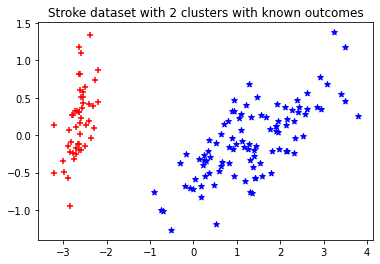

In [ ]:
for i in range(0, k_cluster.shape[0]):
  if df_sub_effects.target[i] == 0:
    c1 = pl.scatter(k_cluster[i,0],k_cluster[i,1],c='r',marker='+')
  
  elif df_sub_effects.target[i] == 1:
    c2 = pl.scatter(k_cluster[i,0],k_cluster[i,1],c='b',marker='*')

  elif df_sub_effects.target[i] == 2:
    c3 = pl.scatter(k_cluster[i,0],k_cluster[i,1],c='b', marker='*')

pl.title('Stroke dataset with 2 clusters with known outcomes')
pl.show()

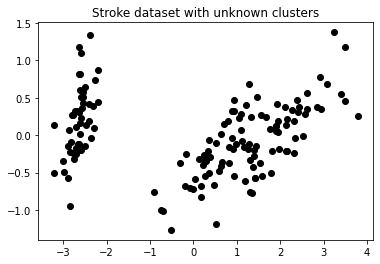

In [ ]:
#starting graph 
pl.scatter(k_cluster[:,0],k_cluster[:,1],c='black')
pl.title('Stroke dataset with unknown clusters')
pl.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [ ]:
numpy_array = np.array(df_sub_effects)
print(type(numpy_array))

<class 'numpy.ndarray'>


In [ ]:
#errorLine
#k_cluster = KMeans(n_clusters=2, n_init=10, max_iter=500).fit(numpy_array)

#returning the array of clusters
kmeans = KMeans(n_clusters= 2)
label = kmeans.fit_predict(df)
print(label)

[1 1 0 ... 0 1 0]


# Spectral Clustering

## Let look at the data and see if the is anything interesting to note before we start with the algorithm

In [ ]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,1,1,228.69,36.6,1,1
1,2,61.0,0,0,1,2,2,202.21,26.5,0,1
2,1,80.0,0,1,1,1,2,105.92,32.5,0,1
3,2,49.0,0,0,1,1,1,171.23,34.4,2,1
4,2,79.0,1,0,1,2,2,174.12,24.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,2,80.0,1,0,1,1,1,83.75,26.5,0,0
5106,2,81.0,0,0,1,2,1,125.20,40.0,0,0
5107,2,35.0,0,0,1,2,2,82.99,30.6,0,0
5108,1,51.0,0,0,1,1,2,166.29,25.6,1,0


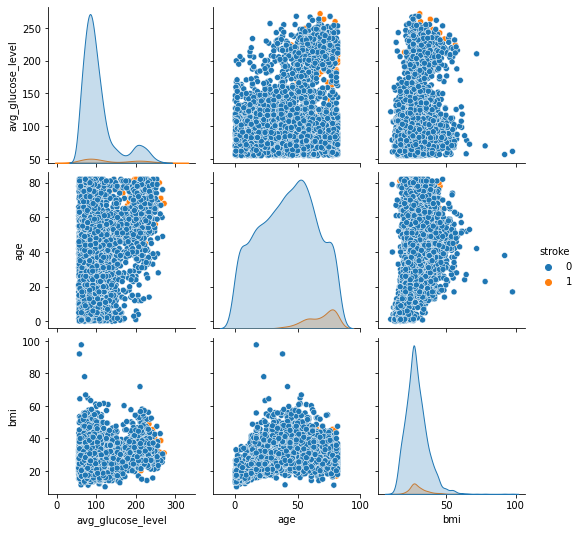

In [ ]:
import seaborn as sns
sns.pairplot(df, hue='stroke', vars =['avg_glucose_level','age','bmi'])

#### There does not seem to be anything standing out with the bmi, age, or glucose level

------------------------------------------------------------------------------

### Let's see if there is anything else we can see from grouping the categorical and variable data points

In [ ]:
strokes = df['stroke']

In [ ]:
noStroke = df.drop(['stroke'],axis=1)




### In order to properly check the distances between values, we are going to standardize all the data using a z score. 


To do this we are going to use the equation: 

\begin{align}
        Z = \frac{x - μ}{σ}
      \end{align}
      
Through the scripy's zscore function


In [ ]:
from scipy.stats import zscore

##### We are going to standardize the data and then grouping it based on whether it is categorical or variable 

In [ ]:
noStrokeZScore = noStroke.apply(zscore)


In [ ]:
catGrouped = noStrokeZScore['gender'] + noStrokeZScore['hypertension'] + noStrokeZScore['heart_disease'] + noStrokeZScore['ever_married'] + noStrokeZScore['Residence_type'] + noStrokeZScore['smoking_status'] + noStrokeZScore['work_type']

In [ ]:
varGrouped = noStrokeZScore['age'] + noStrokeZScore['avg_glucose_level'] + noStrokeZScore['bmi']

In [ ]:
newDataFrame = pd.DataFrame()
newDataFrame['catVals'] = catGrouped
newDataFrame['variableVals'] = varGrouped
newDataFrame['stroke'] = strokes
newDataFrame

,catVals,variableVals,stroke
0,1.348791,4.769242,1
1,1.052931,2.609195,1
2,2.554088,2.101066,1
3,-0.251389,2.418814,1
4,4.424729,2.460690,1
...,...,...,...
5105,1.530488,0.833299,0
5106,-0.947326,3.543769,0
5107,1.052931,-0.641990,0
5108,-1.074930,1.256899,0


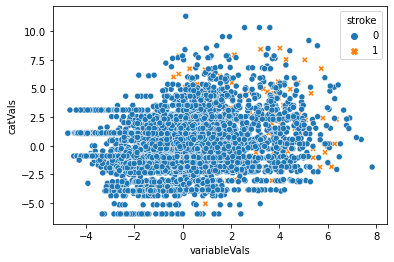

In [ ]:
sns.scatterplot(data=newDataFrame,x='variableVals',y='catVals',hue="stroke",style="stroke")

### Again there is nothing really standing out from doing this so lets keep looking

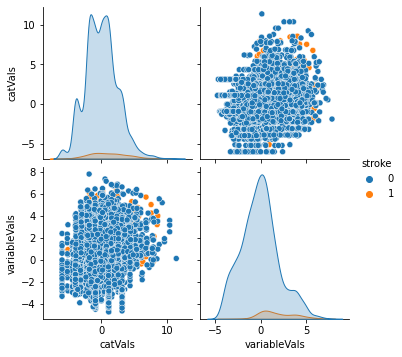

In [ ]:
sns.pairplot(newDataFrame, hue = 'stroke')

### Lets try removing the stroke column and see if anything changes

In [ ]:
newDataFrameNoStroke = newDataFrame.drop(['stroke'], axis=1)
newDataFrameNoStroke

,catVals,variableVals
0,1.348791,4.769242
1,1.052931,2.609195
2,2.554088,2.101066
3,-0.251389,2.418814
4,4.424729,2.460690
...,...,...
5105,1.530488,0.833299
5106,-0.947326,3.543769
5107,1.052931,-0.641990
5108,-1.074930,1.256899


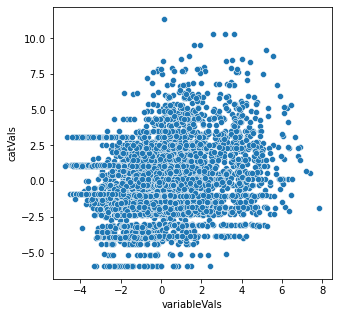

In [ ]:
plt.figure(figsize=(5, 5))
plot = sns.scatterplot(data=newDataFrameNoStroke,x='variableVals',y='catVals')


#### Again there is nothing really to see so lets try another approach
------------------------------------------------------------------------------

### Let's find the Euclidean distance of all the columns and then take the square forms of them to see if we can find some type of relationship

#### First we are going to have to standardize the data

In [ ]:
from scipy.stats import zscore
dfSTD = df.apply(zscore)
dfSTD

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,-1.189511,1.051434,-0.328602,4.185032,0.723884,-0.749127,-0.984080,2.706375,1.011432,-0.308806,4.418381
1,0.839328,0.786070,-0.328602,-0.238947,0.723884,0.144857,1.016178,2.121559,-0.298433,-1.103767,4.418381
2,-1.189511,1.626390,-0.328602,4.185032,0.723884,-0.749127,1.016178,-0.005028,0.479704,-1.103767,4.418381
3,0.839328,0.255342,-0.328602,-0.238947,0.723884,-0.749127,-0.984080,1.437358,0.726115,0.486155,4.418381
4,0.839328,1.582163,3.043196,-0.238947,0.723884,0.144857,1.016178,1.501184,-0.622657,-1.103767,4.418381
...,...,...,...,...,...,...,...,...,...,...,...
5105,0.839328,1.626390,3.043196,-0.238947,0.723884,-0.749127,-0.984080,-0.494658,-0.298433,-1.103767,-0.226327
5106,0.839328,1.670617,-0.328602,-0.238947,0.723884,0.144857,-0.984080,0.420775,1.452377,-1.103767,-0.226327
5107,0.839328,-0.363842,-0.328602,-0.238947,0.723884,0.144857,1.016178,-0.511443,0.233294,-1.103767,-0.226327
5108,-1.189511,0.343796,-0.328602,-0.238947,0.723884,-0.749127,1.016178,1.328257,-0.415154,-0.308806,-0.226327


###Now that we have standardized our values we can find the euclidan distance between our values. Can obtain these values through scipy's pdist functiion

#### We are going to import **pdist** and **sqaureform** 

In [ ]:
from scipy.spatial.distance import squareform, pdist

#### In order for the function to work correctly we need to transpose the data

In [ ]:
dfSTDT = dfSTD.T

In [ ]:
pairwise = pd.DataFrame(
    squareform(pdist(dfSTDT)),
    columns = dfSTDT.index,
    index = dfSTDT.index
)
pairwise

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,0.000000,99.704526,102.169500,105.339246,99.598603,104.387175,101.373090,103.798174,99.703451,105.295266,101.557999
age,99.704526,0.000000,85.995443,86.741027,57.265543,120.181599,101.808250,88.237697,83.321378,115.306066,87.826362
hypertension,102.169500,85.995443,0.000000,95.462620,92.419887,104.821221,100.693220,91.852478,92.962693,106.954832,94.407748
heart_disease,105.339246,86.741027,95.462620,0.000000,95.122751,103.997337,101.250187,92.551705,99.409805,102.483421,94.027544
ever_married,99.598603,57.265543,92.419887,95.122751,0.000000,118.583938,101.409994,92.925816,82.563583,113.103273,95.460818
work_type,104.387175,120.181599,104.821221,103.997337,118.583938,0.000000,101.827960,104.481295,117.033285,84.509384,103.995436
Residence_type,101.373090,101.808250,100.693220,101.250187,101.409994,101.827960,0.000000,100.843718,101.063869,101.886389,101.872373
avg_glucose_level,103.798174,88.237697,91.852478,92.551705,92.925816,104.481295,100.843718,0.000000,92.486728,104.745914,94.188734
bmi,99.703451,83.321378,92.962693,99.409805,82.563583,117.033285,101.063869,92.486728,0.000000,111.289724,99.539297
smoking_status,105.295266,115.306066,106.954832,102.483421,113.103273,84.509384,101.886389,104.745914,111.289724,0.000000,102.930027


### We used pdist to find the euclidian distance and sqaureform to create an affinity matrix

#### Lets plot our square matrix with a heatmap to better visualize our results

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

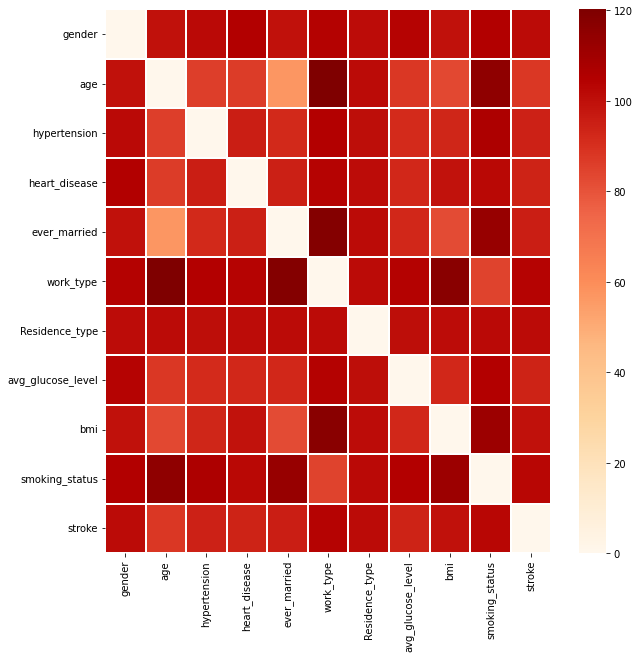

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(
    pairwise,
    cmap='OrRd',
    linewidth=1
)

#### We can see that the forumla worked correctly but it does not seem like there are any concrete relationships



### Lets check out the cosine distance and see if we can find anything else

In [ ]:
A = pd.DataFrame(
    squareform(pdist(dfSTDT,metric="cosine")),
    columns = dfSTDT.index,
    index = dfSTDT.index
)
A

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
gender,0.000000,0.972700,1.021390,1.085749,0.970634,1.066212,1.005529,1.054213,0.972679,1.084843,1.009200
age,0.972700,0.000000,0.723602,0.736204,0.320875,1.413270,1.014180,0.761829,0.679301,1.300928,0.754743
hypertension,1.021390,0.723602,0.000000,0.891694,0.835757,1.075097,0.992087,0.825526,0.845603,1.119309,0.872096
heart_disease,1.085749,0.736204,0.891694,0.000000,0.885356,1.058263,1.003092,0.838143,0.966958,1.027676,0.865086
ever_married,0.970634,0.320875,0.835757,0.885356,0.000000,1.375944,1.006261,0.844932,0.667001,1.251698,0.891660
work_type,1.066212,1.413270,1.075097,1.058263,1.375944,0.000000,1.014573,1.068135,1.340195,0.698810,1.058224
Residence_type,1.005529,1.014180,0.992087,1.003092,1.006261,1.014573,0.000000,0.995054,0.999404,1.015737,1.015458
avg_glucose_level,1.054213,0.761829,0.825526,0.838143,0.844932,1.068135,0.995054,0.000000,0.836966,1.073552,0.868055
bmi,0.972679,0.679301,0.845603,0.966958,0.667001,1.340195,0.999404,0.836966,0.000000,1.211879,0.969479
smoking_status,1.084843,1.300928,1.119309,1.027676,1.251698,0.698810,1.015737,1.073552,1.211879,0.000000,1.036653


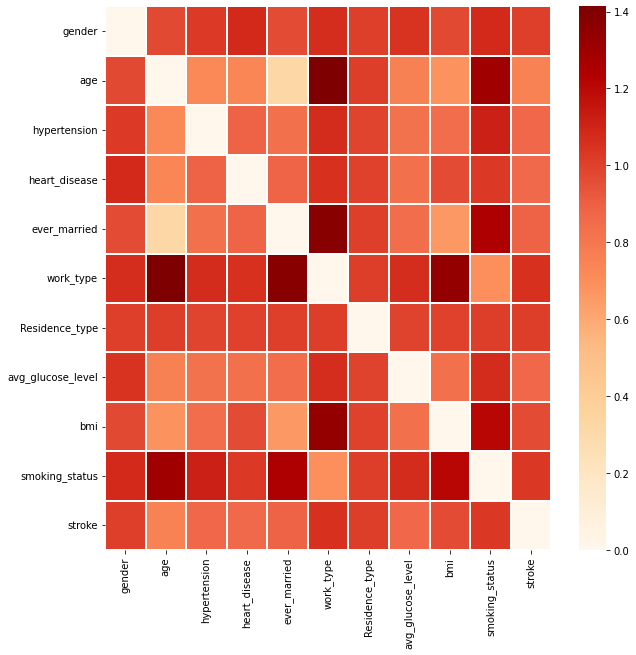

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(
    A,
    cmap="OrRd",
    linewidth = 1
)

### Unfortunately the cosine distance does not reveal much more, it only reinforces that there is some sort of correlation bewtween evermarried and age. Considering the fact that the married column is a yes or no response our group does not think that it is worth while to look into this relationship. Below we plotted a scatterplot to confirm our suspicion.



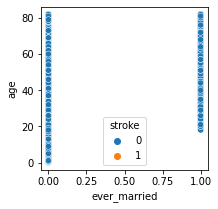

In [ ]:
plt.figure(figsize=(3, 3))
sns.scatterplot(data=df,x='ever_married',y='age',hue='stroke')

## Since our group is interested in performing a spectral culstering algorithm we chose to just focus on the avgerage glucose level and bmi column.

### We chose these two columns because it has 2 fairly distinct groups that k-means would struggle with. You can see this visually below.

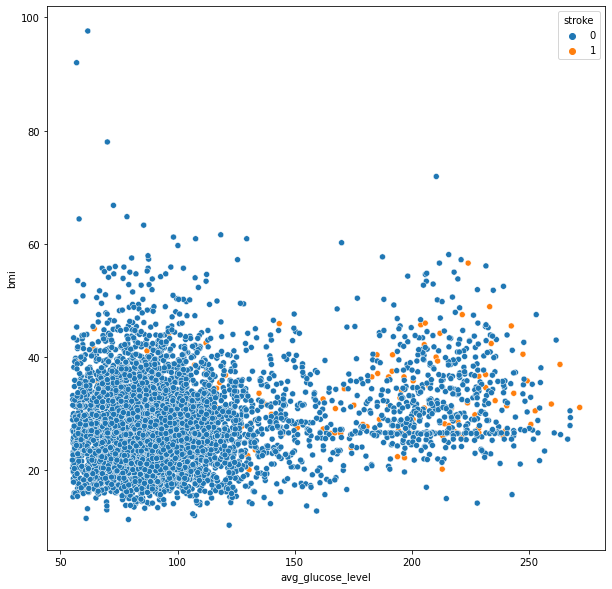

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df,x='avg_glucose_level',y='bmi',hue='stroke')

### Lets make a table that only has AGL and BMI

In [ ]:
ggTry = pd.DataFrame()
ggTry['bmi'] = df['bmi']
ggTry['avg_glucose_level'] = df['avg_glucose_level']
ggTry

,bmi,avg_glucose_level
0,36.6,228.69
1,26.5,202.21
2,32.5,105.92
3,34.4,171.23
4,24.0,174.12
...,...,...
5105,26.5,83.75
5106,40.0,125.20
5107,30.6,82.99
5108,25.6,166.29


In [ ]:
specArray = ggTry.to_numpy()


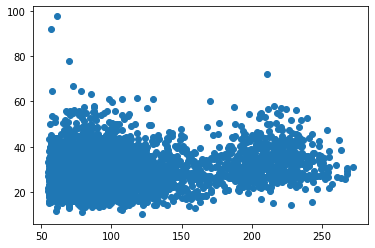

In [ ]:
plt.scatter(specArray[:,1],specArray[:,0])
plt.show()

In [ ]:
sampledDF = ggTry.sample(n=500)
sampledDF

,bmi,avg_glucose_level
3079,20.1,98.65
1511,30.7,123.49
3755,24.0,138.55
2094,30.1,107.27
2237,34.3,88.48
...,...,...
4789,31.0,89.32
1959,20.8,82.73
12,27.3,104.51
3268,16.0,99.75


In [ ]:
specArraySample = sampledDF.to_numpy()

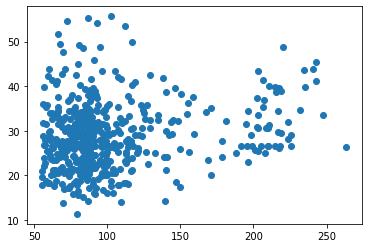

In [ ]:
plt.scatter(specArraySample[:,1],specArraySample[:,0])
plt.show()

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from numpy import random

In [ ]:
sc = SpectralClustering(n_clusters = 2).fit(specArraySample)
SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='amg', eigen_tol=0.0, gamma=.75,
                   kernel_params=None, n_clusters=2, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=5, random_state=None) 

SpectralClustering(eigen_solver='amg', gamma=0.75, n_clusters=2, n_neighbors=5)

In [ ]:
labels = sc.labels_

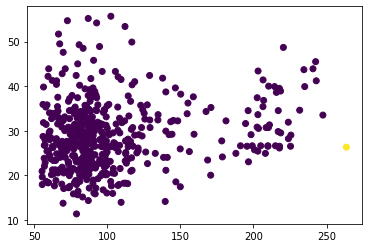

In [ ]:
plt.scatter(specArraySample[:,1],specArraySample[:,0],c=labels)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:379: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:379: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:379: ConvergenceWarning: Number of distinct clusters (2) found

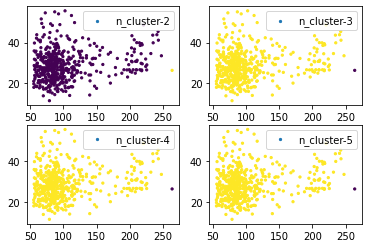

In [ ]:
fig = plt.figure()
fig.add_subplot(2, 2, 1)
for i in range(2, 6):
 sc = SpectralClustering(n_clusters=i).fit(specArraySample)
 fig.add_subplot(2, 2, i-1)
 plt.scatter(specArraySample[:,1], specArraySample[:,0], s=5, c=sc.labels_, label="n_cluster-"+str(i))
 plt.legend()
plt.show()